#### Pacotes para instalação
Execute a linha abaixo para instalar os pacotes empregados neste notebook.

In [ ]:
!%pip install pandas matplotlib seaborn scikit-learn

#### Imports necessários

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#### Carregamento dos dados

In [259]:
df = pd.read_csv("desafio_indicium_imdb.csv", sep=',')
df = df.drop(df.columns[0], axis=1)
df.tail()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
994,Breakfast at Tiffany's,1961,A,115 min,"Comedy, Drama, Romance",7.6,A young New York socialite becomes interested ...,76.0,Blake Edwards,Audrey Hepburn,George Peppard,Patricia Neal,Buddy Ebsen,166544,NaN
995,Giant,1956,G,201 min,"Drama, Western",7.6,Sprawling epic covering the life of a Texas ca...,84.0,George Stevens,Elizabeth Taylor,Rock Hudson,James Dean,Carroll Baker,34075,NaN
996,From Here to Eternity,1953,Passed,118 min,"Drama, Romance, War",7.6,"In Hawaii in 1941, a private is cruelly punish...",85.0,Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,43374,"30,500,000"
997,Lifeboat,1944,NaN,97 min,"Drama, War",7.6,Several survivors of a torpedoed merchant ship...,78.0,Alfred Hitchcock,Tallulah Bankhead,John Hodiak,Walter Slezak,William Bendix,26471,NaN
998,The 39 Steps,1935,NaN,86 min,"Crime, Mystery, Thriller",7.6,A man in London tries to help a counter-espion...,93.0,Alfred Hitchcock,Robert Donat,Madeleine Carroll,Lucie Mannheim,Godfrey Tearle,51853,NaN


#### Tratamento dos tipos de dado de cada coluna

In [260]:
df = df.dropna()
df.Gross = df.Gross.str.replace(",", "", regex=False).astype(int)
df.Genre = df.Genre.str.replace(" ", "", regex=False)
df.Genre = df.Genre.str.split(',')
df.Released_Year = df.Released_Year.astype(int)
df.IMDB_Rating = df.IMDB_Rating.astype(float)
df.Meta_score = df.Meta_score.astype(float)
df.Runtime = df.Runtime.str.replace(" min", "", regex=False).astype(int)

#### Observação importante
Como na base de dados a títulos datam de 1930, é importante trazer o faturamento a valor presente corrigido pela inflação. Um dólar acumulado em 1930 corrigido pela inflação valeria $19,34 o que em média foi de 3,17% ao ano. Para padronização vou aplicar para todos os títulos e criar uma coluna Gross_adjusted levando em consideração o ano de cada título. Fonte: https://www.usinflationcalculator.com/

In [261]:
df['Gross_adjusted'] = df.apply(lambda row: row['Gross'] * ((1 + 0.0317) ** (2025 - row['Released_Year'])), axis=1)

### Faturamento por diretor


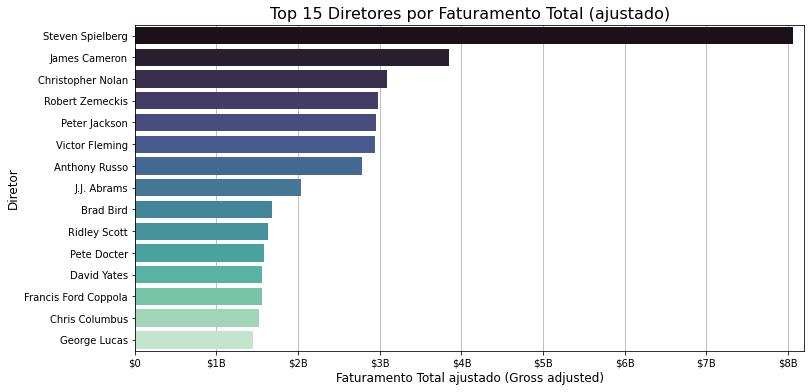

In [262]:
director_gross = df.groupby('Director')['Gross_adjusted'].sum().sort_values(ascending=False)
#print(director_gross.apply(lambda x: f"${x:,.2f}"))
director_gross_df = director_gross.reset_index()
director_gross_df.columns = ['Director', 'Gross_adjusted']

# Plotando o gráfico de barra
plt.figure(figsize=(12, 6))
sns.barplot(data=director_gross_df.head(15), x='Gross_adjusted', y='Director', palette='mako')
plt.grid(axis='x')
ax = plt.gca()
ax.set_axisbelow(True)
ticks = ax.get_xticks()
plt.xticks(ticks=ticks, labels=['$0', '$1B', '$2B', '$3B', '$4B', '$5B', '$6B', '$7B', '$8B', '$9B'])
plt.title('Top 15 Diretores por Faturamento Total (ajustado)', fontsize=16)
plt.xlabel('Faturamento Total ajustado (Gross adjusted)', fontsize=12)
plt.xlim(0, 8200000000)
plt.ylabel('Diretor', fontsize=12)
plt.show()

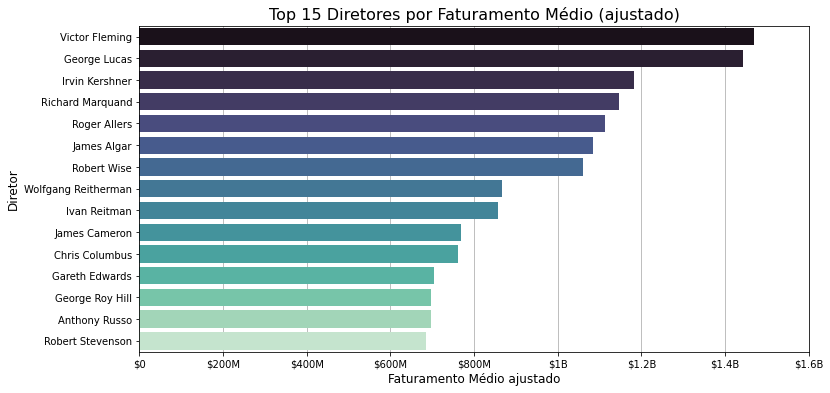

In [263]:
director_gross_mean = df.groupby('Director')['Gross_adjusted'].mean().sort_values(ascending=False)
#print(director_gross_mean.apply(lambda x: f"${x:,.2f}"))
director_gross_mean_df = director_gross_mean.reset_index()
director_gross_mean_df.columns = ['Director', 'Gross_adjusted mean']

# Plotando o gráfico de barra
plt.figure(figsize=(12, 6))
sns.barplot(data=director_gross_mean_df.head(15), x='Gross_adjusted mean', y='Director', palette='mako')
plt.grid(axis='x')
ax = plt.gca()
ax.set_axisbelow(True)
ticks = ax.get_xticks()
plt.xticks(ticks=ticks, labels=['$0', '$200M', '$400M', '$600M', '$800M', '$1B', '$1.2B', '$1.4B', '$1.6B'])
plt.title('Top 15 Diretores por Faturamento Médio (ajustado)', fontsize=16)
plt.xlabel('Faturamento Médio ajustado', fontsize=12)
plt.ylabel('Diretor', fontsize=12)
plt.show()


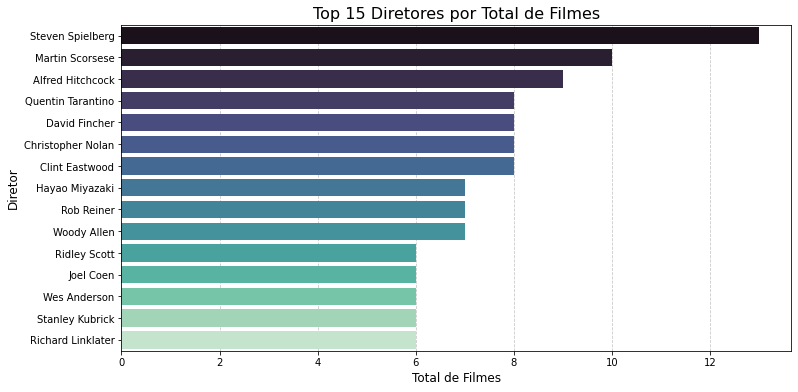

In [264]:
total_per_dir = df.groupby('Director').size().reset_index(name='Total Filmes')
total_per_dir_df = total_per_dir.sort_values(by='Total Filmes', ascending=False)

# Plotando o gráfico de barras horizontais
plt.figure(figsize=(12, 6))
sns.barplot(data=total_per_dir_df.head(15), x='Total Filmes', y='Director', palette='mako')
ax = plt.gca()
ax.set_axisbelow(True)
plt.title('Top 15 Diretores por Total de Filmes', fontsize=16)
plt.xlabel('Total de Filmes', fontsize=12)
plt.ylabel('Diretor', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### Nota por diretor

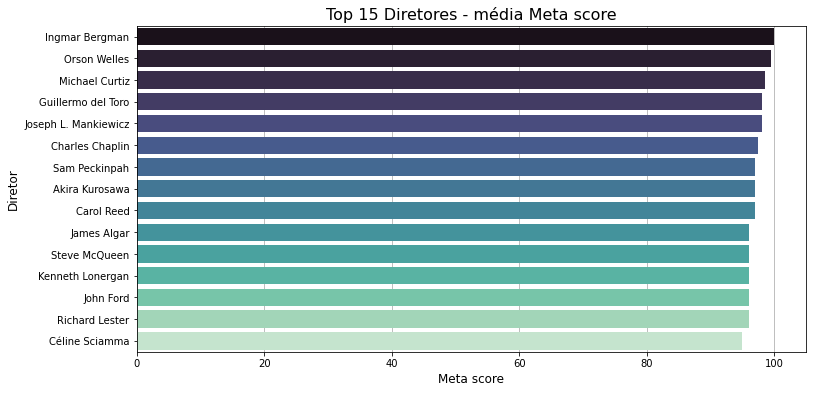

In [265]:
director_meta_score= df.groupby('Director')['Meta_score'].mean().sort_values(ascending=False)
#print(director_meta_score.apply(lambda x: f"${x:,.2f}"))
director_meta_score_df = director_meta_score.reset_index()
director_meta_score_df.columns = ['Director', 'Meta score']

# Plotando o gráfico de barra
plt.figure(figsize=(12, 6))
sns.barplot(data=director_meta_score_df.head(15), x='Meta score', y='Director', palette='mako')
plt.grid(axis='x')
ax = plt.gca()
ax.set_axisbelow(True)
ticks = ax.get_xticks()
plt.title('Top 15 Diretores - média Meta score', fontsize=16)
plt.xlabel('Meta score', fontsize=12)
plt.ylabel('Diretor', fontsize=12)
plt.show()

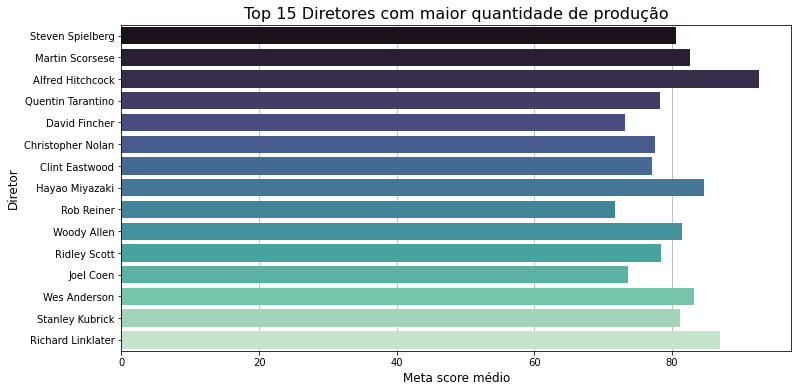

In [266]:
# Mas os resultados acima fazem pouco sentido uma vez que todos os diretrores tem apenas um filme na base de dados.
# Vou filtrar para os diretores que tem o maior quantidade de produção.
director_stats = df.groupby('Director').agg({'Gross_adjusted': 'mean', 'Meta_score': 'mean', 'Series_Title': 'count'}).reset_index()
director_stats.columns = ['Director', 'Faturamento médio (ajustado)', 'Meta score médio', 'Total Filmes']

director_stats = director_stats.sort_values(by='Total Filmes', ascending=False)
#print(director_stats)
plt.figure(figsize=(12, 6))
sns.barplot(data=director_stats.head(15), x='Meta score médio', y='Director', palette='mako')
plt.grid(axis='x')
ax = plt.gca()
ax.set_axisbelow(True)
ticks = ax.get_xticks()
plt.title('Top 15 Diretores com maior quantidade de produção', fontsize=16)
plt.xlabel('Meta score médio', fontsize=12)
plt.ylabel('Diretor', fontsize=12)
plt.show()

In [287]:
best_directors  

,Director,Gross_adjusted,Meta_score,IMDB_Rating
382,Victor Fleming,1.469691e+09,94.500000,8.050000
116,George Lucas,1.443503e+09,90.000000,8.600000
138,Irvin Kershner,1.183078e+09,82.000000,8.700000
304,Richard Marquand,1.146512e+09,58.000000,8.300000
319,Roger Allers,1.112435e+09,88.000000,8.500000
145,James Algar,1.084379e+09,96.000000,7.700000
316,Robert Wise,1.061608e+09,63.000000,8.000000
392,Wolfgang Reitherman,8.667797e+08,65.000000,7.600000
140,Ivan Reitman,8.578662e+08,71.000000,7.800000
146,James Cameron,7.700703e+08,80.200000,8.080000


### Modelo de predição da nota IMDB

In [289]:
# aqui a base de dados será modificada para gerar o modelo de predição da nota IMDB
# Convertendo a coluna 'Genre' em listas\
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df.Genre),
							 columns=mlb.classes_,
							 index=df.index)
df_model = pd.concat([df, genre_encoded], axis=1)
df_corr = df_model.copy()
df_model.drop(columns=['Series_Title', 'Released_Year', 'Genre', 'Director', 'Certificate', 'Overview', 'Star1', 'Star2', 'Star3', 'Star4', 'Gross'], inplace=True)

y = df_model['IMDB_Rating']
X = df_model.drop(columns=['IMDB_Rating'])

In [290]:
# base de dados é pequena, então vou usar 30% para teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2:.4f}')

R^2 Score: 0.5188


In [291]:
input = pd.DataFrame()
input['Runtime'] = [142]
input['Meta_score'] = [80]
input['No_of_Votes'] = 2343110
input['Gross_adjusted'] = 28341469*((1 + 0.0317) ** (2025 - 1994))
gen_model = pd.DataFrame(mlb.transform([['Drama']]), columns=mlb.classes_)

input = pd.concat([input, gen_model], axis=1)
input
predicted_rating = rf_model.predict(input)
print(f'Predicted IMDB Rating for "The Shawshank Redemption": {predicted_rating[0]:.2f}')

Predicted IMDB Rating for "The Shawshank Redemption": 8.80


Text(0.5, 1.0, 'Matriz de Correlação')

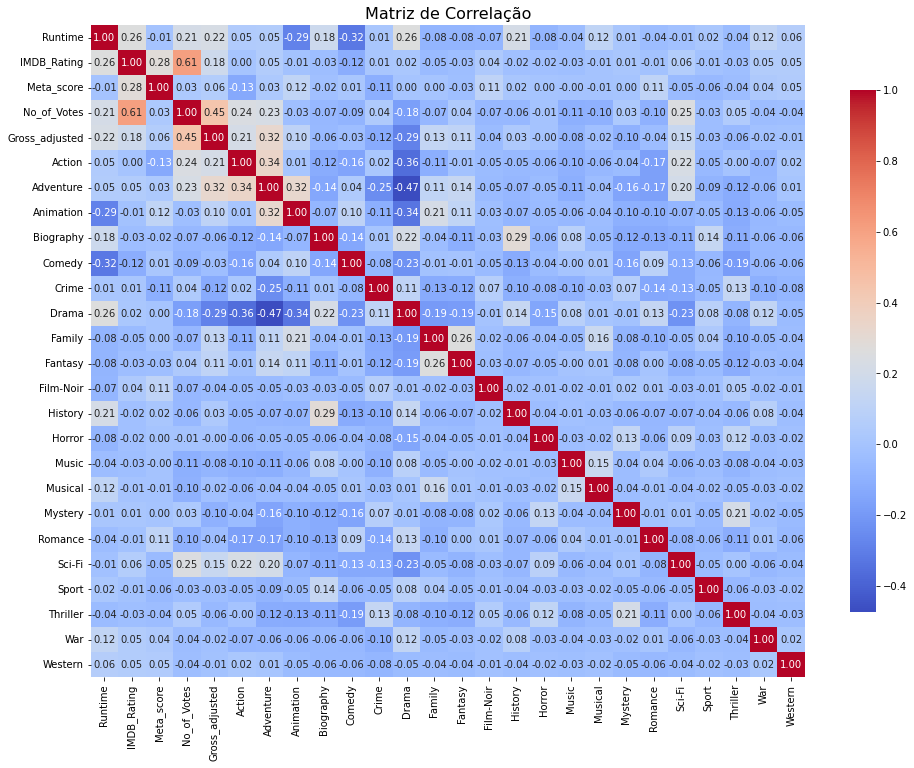

In [ ]:
corr_matrix = df_model.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação', fontsize=16)

### Resto (vai ser excluído no fim)

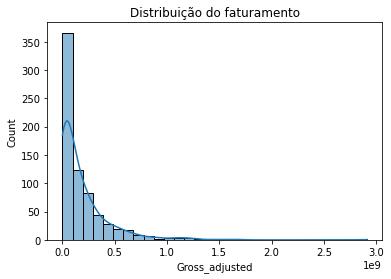

In [88]:
# Distribuição de idades
sns.histplot(df.Gross_adjusted, bins=30, kde=True)
plt.title("Distribuição do faturamento")
plt.show()

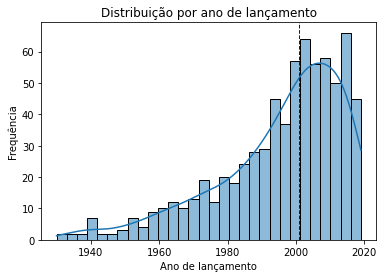

In [95]:
sns.histplot(df.Released_Year, bins=30, kde=True)
plt.title("Distribuição por ano de lançamento")
plt.xlabel("Ano de lançamento")
plt.ylabel("Frequência")
plt.axvline(x=2001, color='b', linestyle='--', linewidth=1)
plt.show()

In [162]:
diretor = 'Frank Darabont'
titles = df[df['Director'] == diretor]
titles

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Gross_adjusted
24,The Green Mile,1999,A,189,"[Crime, Drama, Fantasy]",8.6,The lives of guards on Death Row are affected ...,61.0,Frank Darabont,Tom Hanks,Michael Clarke Duncan,David Morse,Bonnie Hunt,1147794,136801374,3.079496e+08


In [103]:
titles_year = df[df['Released_Year'] <= 2000].count()
titles_year

Series_Title      350
Released_Year     350
Certificate       350
Runtime           350
Genre             350
IMDB_Rating       350
Overview          350
Meta_score        350
Director          350
Star1             350
Star2             350
Star3             350
Star4             350
No_of_Votes       350
Gross             350
Gross_adjusted    350
dtype: int64